In [1]:
%load_ext autoreload
%autoreload 2

# tanh and BN with 1 layer, euclidean distance between each layer

In [2]:
from modules import *

In [3]:
torch.cuda.is_available()

True

In [4]:
device = 'cpu' #'cuda:0' if torch.cuda.is_available() else 'cpu'

In [5]:
nvidia_smi.nvmlInit()
cuda = nvidia_smi.nvmlDeviceGetHandleByIndex(0)

In [5]:
config = Config('config-Copy15.json')

In [6]:
config[...]

{'name': 'tanh_bn_uwlayers_repoch',
 'batchsize': 60,
 'epoch': {'start': 0, 'end': None},
 'lr': {'initial': 0.001,
  'decay_rate': 0.99,
  'decay_step': 1,
  'override': None},
 'log_period': 1,
 'test': {'name': 'tanh_bn_uwlayers_repoch',
  'epoch': 156,
  'out_prefix': 'tanh_bn_uwlayers_repoch'}}

In [17]:
class Net_NOD_BN_Skip_SuperDeep(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.n_layers = 22
        
        out_len = 2
        in_vf_lens = [2, 8] + [16] * (self.n_layers - 3) + [8]
        out_vf_lens = in_vf_lens[1:] + [out_len]
        in_ef_lens = [2] + [3] * (self.n_layers - 1)
        layer_bn = [True] * (self.n_layers - 1) + [False]
        layer_dp = [0.2] * (self.n_layers - 2) + [None] * 2
        
        self.skip = {
            0: None, 
            1: None,
            2: None, 
            3: 2, 
            4: None, 
            5: 4, 
            6: None, 
            7: 6, 
            8: None, 
            9: 8, 
            10: None, 
            11: 10, 
            12: None, 
            13: 12, 
            14: None, 
            15: 14, 
            16: None, 
            17: 16, 
            18: None,
            19: 18,
            20: None,
            21: None
        }
        
        self.conv = nn.ModuleList()
        self.bn = nn.ModuleList()
        self.dp = nn.ModuleList()
        self.relu = nn.LeakyReLU()
        
        for layer in range(self.n_layers):
            efeat_net = nn.Sequential(
                Linear(in_ef_lens[layer], in_vf_lens[layer] * out_vf_lens[layer]),
                nn.BatchNorm1d(in_vf_lens[layer] * out_vf_lens[layer]),
                nn.Tanh()
            )
            self.conv.append(NNConv(in_vf_lens[layer], out_vf_lens[layer], efeat_net, aggr='mean'))
            self.bn.append(BatchNorm(out_vf_lens[layer]) if layer_bn[layer] else Identity())
            self.dp.append(Dropout(layer_dp[layer]) if layer_dp[layer] is not None else Identity())
#             self.act.append(nn.LeakyReLU() if layer != self.n_layers - 1 else Identity())

    def _layer(self, idx, data, v_feat, e_feat, act=True, skip_conn=None):
        vout = self.dp[idx](self.relu(self.bn[idx](self.conv[idx](v_feat, data.edge_index, e_feat))))
        vout = vout if skip_conn is None else vout + skip_conn
        eout = torch.cat([data.edge_attr, get_euclidian(vout, data)[0]], dim=1)
        return vout, eout
            
    def forward(self, data):
        x, e = [], []
        
        x.append(data.x)
        e.append(data.edge_attr)
        
        for layer in range(self.n_layers):
            skip_conn = None if self.skip[layer] is None else x[self.skip[layer]]
            x_, e_ = self._layer(layer, data, x[layer], e[layer], skip_conn=skip_conn)
            x.append(x_)
            e.append(e_)

        return x[-1]

In [40]:
G_list, data_list = load_processed_data()

In [9]:
loader = DataLoader(data_list[:10000], batch_size=config['batchsize'],shuffle=True)
loss_ep = []

In [11]:
start_epoch = config['epoch']['start']
if start_epoch == 0:
    model = Net_NOD_BN_Skip_SuperDeep().to(device)
else:
    model = torch.load(f"../ckpt_{config['name']}/epoch_{start_epoch}.pt").to(device)
criterion = EnergyLossVectorized()
optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr']['initial'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, 
                                            step_size=config['lr']['decay_step'], 
                                            gamma=config['lr']['decay_rate'])
print("=" * 50, file=open(f"{config['name']}.log", "a"))
epoch = start_epoch + 1
with tqdm(total=len(loader), smoothing=0) as progress:
    while True:
        if config['lr']['override'] is not None:
            optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr']['override'])
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, 
                                                        step_size=config['lr']['decay_step'], 
                                                        gamma=config['lr']['decay_rate'])
        progress.reset()
        progress.set_description(desc=f"[epoch {epoch}/{config['epoch']['end']}]")
        train_loss = train(model, criterion, optimizer, loader, data_list, device, progress, cuda)
        loss_ep.append(train_loss)
        scheduler.step()
        if epoch == 1 and config['log_period'] != 1:
            print(epoch, loss, scheduler.get_lr(), file=open(f"{config['name']}.log", "a"))
        if epoch % config['log_period'] == 0:
            torch.save(model, f"../ckpt_{config['name']}/epoch_{epoch}.pt")
            test_loss = []
            for val_idx in range(11000, len(G_list)):
                node_pos,loss = evaluate(model, data_list[val_idx],criterion,device)
                test_loss.append(loss)
            print(f'{epoch}, train: {train_loss}, val:{np.mean(test_loss)}，{scheduler.get_lr()}', 
                  file=open(f"{config['name']}.log", "a"))
        if epoch == config['epoch']['end']:
            break
        epoch += 1

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Net_NOD_BN_Skip_SuperDeep. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


RuntimeError: CUDA out of memory. Tried to allocate 128.00 MiB (GPU 0; 15.90 GiB total capacity; 10.14 GiB already allocated; 60.88 MiB free; 10.31 GiB reserved in total by PyTorch)

# Performance Testing

In [ ]:
model = torch.load(f'../ckpt_{config["name"]}/epoch_{config["test"]["epoch"]}.pt', map_location=torch.device(device))
criterion = EnergyLossVectorized()
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
ground_truth = pd.read_csv('ground_truth_loss.csv', index_col=0)

In [ ]:
folder_name = f'{config["test"]["name"]}_test'
test_loss = []
test_loss_ratio=[]
for test_idx in tqdm(range(10000, 11000)):
    G_vis = G_list[test_idx]
    node_pos,loss = evaluate(model, data_list[test_idx],criterion,device)
    gt_loss = ground_truth.loc[test_idx][0]
    loss_ratio = (loss - gt_loss) / gt_loss
    test_loss.append(loss)
    test_loss_ratio.append(loss_ratio)
    graph_vis(G_vis, node_pos, f'{folder_name}/{config["test"]["out_prefix"]}_model_{test_idx}_{loss}_{loss_ratio}.png') 
#     node_pos = nx.nx_agraph.graphviz_layout(G_vis, prog='neato')
#     plt.figure()
#     nx.draw(G_vis, node_pos)
#     plt.savefig(f'{folder_name}/{test_idx}.png')

print(np.nanmean(test_loss), np.nanstd(test_loss))

print(np.nanmean(test_loss_ratio), np.nanstd(test_loss_ratio))

In [ ]:
losses = []
loss_ratios = []
for test_idx in tqdm(range(10000, 11000)):
    G_vis = G_list[test_idx]
    node_pos, loss = evaluate(model, data_list[test_idx], criterion, device)
    gt_loss = ground_truth.loc[test_idx][0]
    loss_ratio = (loss - gt_loss) / gt_loss
    losses += [loss]
    loss_ratios += [loss_ratio]

In [ ]:
np.mean(losses), np.std(losses)

In [ ]:
np.mean(loss_ratios), np.std(loss_ratios)

In [ ]:
truth_loss = 0
pred_loss = 0
for idx in tqdm(range(10000, 11000)):
    pred, loss = evaluate(model, data_list[idx], criterion, device)
    pos_map = nx.nx_agraph.graphviz_layout(G_list[idx], prog='neato')

    pred_mean, pred_std = pred.mean(axis=0), pred.std()
    truth = np.array(list(pos_map.values()))
    truth_mean, truth_std = truth.mean(axis=0), truth.std()
    norm_truth = (truth - truth_mean) / truth_std
    scaled_truth = norm_truth * pred_std + pred_mean

    truth_loss += criterion(torch.tensor(scaled_truth), data_list[idx])
    pred_loss += criterion(torch.tensor(pred), data_list[idx])
    
truth_loss / 1000, pred_loss / 1000

In [ ]:
type(data_list[9999].x)

In [ ]:
iterations = 5
losses = []
folder_name = f'{config["test"]["name"]}_iterative_test'
for test_idx in tqdm(range(10000, len(G_list))):
    G_vis = G_list[test_idx]
    node_pos = nx.nx_agraph.graphviz_layout(G_vis, prog='neato')
    plt.figure()
    nx.draw(G_vis, node_pos)
    plt.savefig(f'{folder_name}/{test_idx}.png')
    for i in range(iterations):
        node_pos, loss = evaluate(model, data_list[test_idx], criterion, device) 
        data_list[test_idx].x = torch.tensor(node_pos,dtype=torch.float)
    losses += [loss]
    graph_vis(G_vis, node_pos, f'{folder_name}/{config["test"]["out_prefix"]}_iter_model_{test_idx}_{loss}.png')

In [ ]:
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(loss_ep[:1000])
plt.show()

In [ ]:
np

In [ ]:
class EnergyLossScaled(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, p, data, scale):
        edge_attr = data.edge_attr
        # convert per-node positions to per-edge positions
        start, end, n_nodes = node2edge(p, data)
        
        start *= scale
        end *= scale
        
        start_x = start[:, 0]
        start_y = start[:, 1]
        end_x = end[:, 0]
        end_y = end[:, 1]
        
        l = edge_attr[:, 0]
        k = edge_attr[:, 1]
        
        term1 = (start_x - end_x) ** 2
        term2 = (start_y - end_y) ** 2
        term3 = l ** 2
        term4 = 2 * l * (term1 + term2).sqrt()
        energy = k / 2 * (term1 + term2 + term3 - term4)
        return energy.sum()

In [ ]:
criterion_scaled = EnergyLossScaled()
criterion = EnergyLossVectorized()

In [ ]:
truth_loss = 0
pred_loss = 0
for idx in tqdm(range(10000, 11000)):
    pred, loss = evaluate(model, data_list[idx], criterion, device)
    pos_map = nx.nx_agraph.graphviz_layout(G_list[idx], prog='neato')

    pred_mean, pred_std = pred.mean(axis=0), pred.std()
    truth = np.array(list(pos_map.values()))
    truth_mean, truth_std = truth.mean(axis=0), truth.std()
    norm_truth = (truth - truth_mean) / truth_std
    scaled_truth = norm_truth * pred_std + pred_mean

    truth_loss += criterion(torch.tensor(scaled_truth, device=device), data_list[idx])
    pred_loss += criterion(torch.tensor(pred, device=device), data_list[idx])
    
truth_loss / 1000, pred_loss / 1000

In [ ]:
for idx in [10898, 10904]:#tqdm(range(10000, 11000)):
    data, G = data_list[idx], G_list[idx]
    edge_attr = data.edge_attr
    pred, loss = evaluate(model, data, criterion, device)
    pos_map = nx.nx_agraph.graphviz_layout(G, prog='neato')
    truth = np.array(list(pos_map.values()))

    start, end, n_nodes = node2edge(torch.tensor(truth, device=device), data)
    w = edge_attr[:, 1]
    d = edge_attr[:, 0]

    u2 = ((start - end) ** 2).sum(dim=1)

    s = (w * d * u2.sqrt()).sum() / (w * u2).sum()

    loss_gt = criterion_scaled(torch.tensor(truth, device=device), data, s)

    print(loss, loss_gt)

In [ ]:
def evaluate(model, data, criterion, device, idx):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        pred = model(data).detach()
        loss = criterion(pred,data).cpu().numpy()
        loss = round(float(loss),2)
    return pred.cpu().numpy(), loss

def graph_vis(G, node_pos):
    i = 0
    for n, p in node_pos:
        node = 'n' +str(i)
        G.nodes[node]['pos'] = (n,p)
        i += 1
    pos = nx.get_node_attributes(G,'pos')
    plt.figure()
    nx.draw(G, pos)
    
for test_idx in tqdm(list(range(10000, len(data_list)))):
    G_vis = G_list[test_idx]
    node_pos,loss = evaluate(model, data_list[test_idx],criterion,device, test_idx)
    if loss > 10000:
        print(test_idx, loss, data_list[test_idx].num_nodes)
        graph_vis(G_vis, node_pos) 
        node_pos = nx.nx_agraph.graphviz_layout(G_vis, prog='neato')
        plt.figure()
        nx.draw(G_vis, node_pos)

# repeatedly eval

In [42]:
model = torch.load(f'../ckpt_{config["name"]}/epoch_{config["test"]["epoch"]}.pt', map_location=torch.device(device))
criterion = EnergyLossVectorized()

tensor(183.3323, grad_fn=<SumBackward0>)
tensor(189.4040, grad_fn=<SumBackward0>)
tensor(190.8463, grad_fn=<SumBackward0>)
tensor(184.7384, grad_fn=<SumBackward0>)
tensor(189.0362, grad_fn=<SumBackward0>)
tensor(187.2336, grad_fn=<SumBackward0>)
tensor(184.0612, grad_fn=<SumBackward0>)
tensor(192.1263, grad_fn=<SumBackward0>)
tensor(185.6870, grad_fn=<SumBackward0>)
tensor(186.4474, grad_fn=<SumBackward0>)


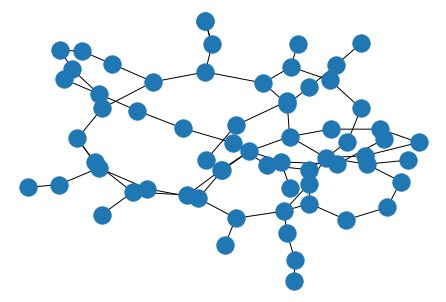

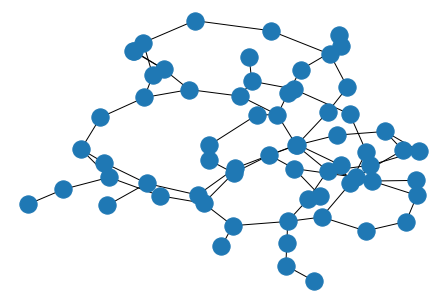

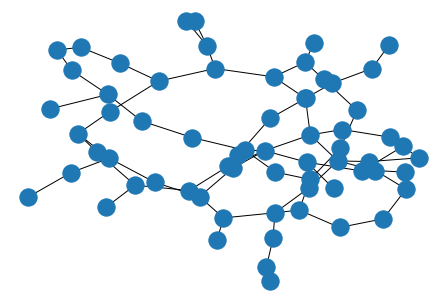

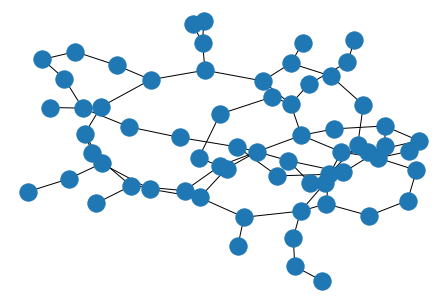

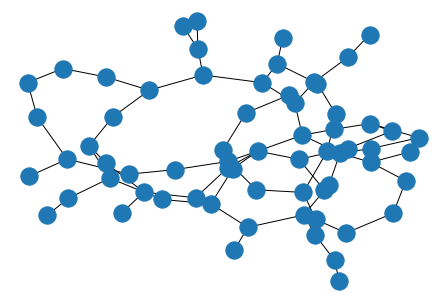

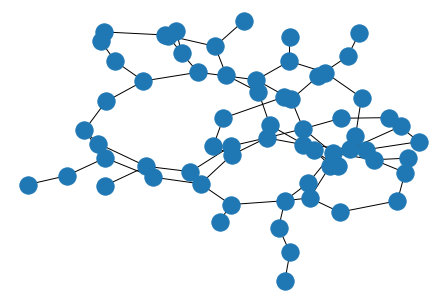

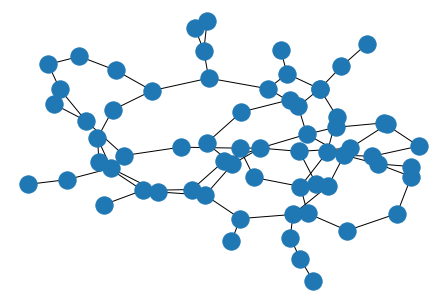

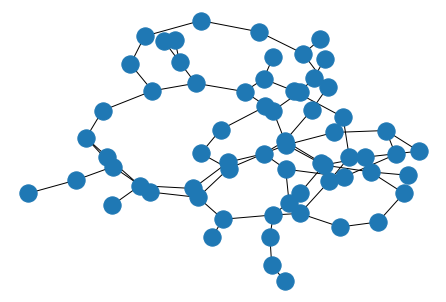

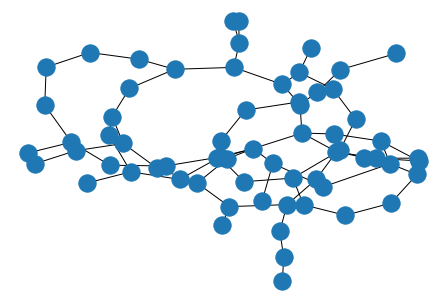

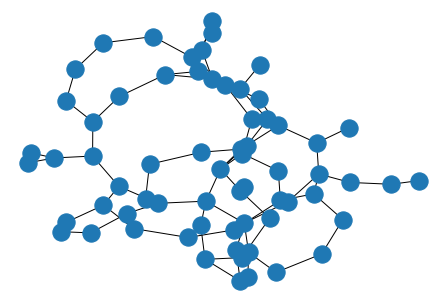

In [43]:
idx = 10117
G, data = G_list[idx], data_list[idx]

d = data
for i in range(10):
    d.x = model(d)
    print(criterion(d.x, data))
    graph_vis(G, d.x)